In [2]:
import autogluon as ag
import mxnet as mx
import mxnet.gluon.nn as nn

In [52]:
from autogluon.contrib.enas import *
from gluoncv.model_zoo.cifarresnet import CIFARResNetV1, CIFARBasicBlockV1

In [48]:
layers = [1, 1, 1]
channels = [16, 16, 32, 64]
net = CIFARResNetV1(CIFARBasicBlockV1, layers, channels)

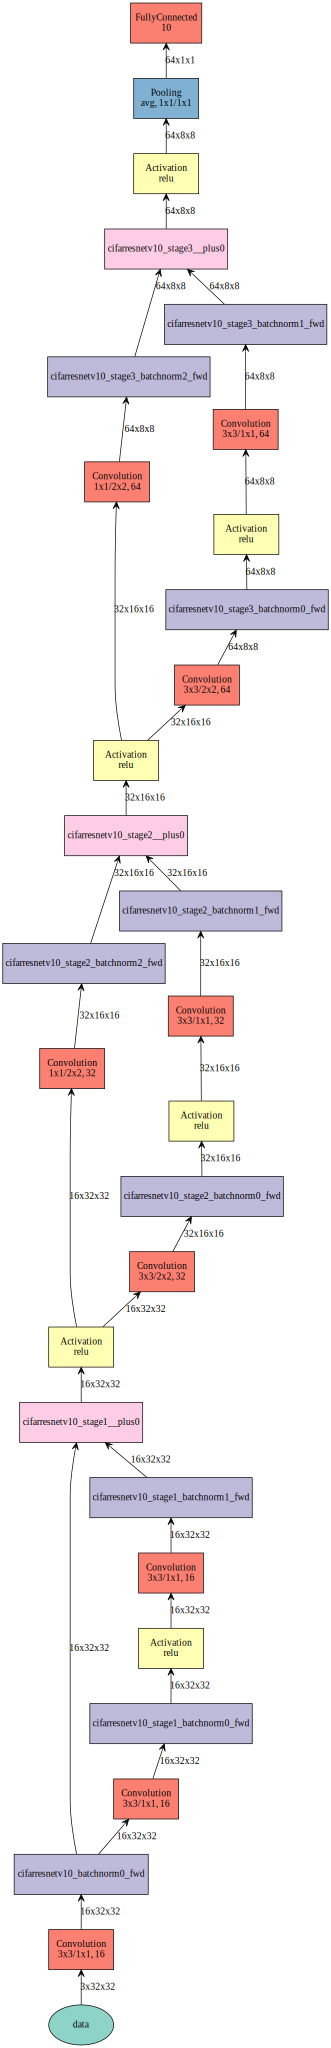

In [49]:
ag.utils.plot_network(net, (1, 3, 32, 32))

In [50]:
class Identity(mx.gluon.HybridBlock):
    def hybrid_forward(self, F, x):
        return x

class ConvBNReLU(mx.gluon.HybridBlock):
    def __init__(self, in_channels, channels, kernel, stride):
        super().__init__()
        padding = (kernel - 1) // 2
        self.conv = nn.Conv2D(channels, kernel, stride, padding, in_channels=in_channels)
        self.bn = nn.BatchNorm(in_channels=channels)
        self.relu = nn.Activation('relu')
    def hybrid_forward(self, F, x):
        return self.relu(self.bn(self.conv(x)))

In [53]:
@enas_unit()
class ResUnit(mx.gluon.HybridBlock):
    def __init__(self, in_channels, channels, hidden_channels, kernel, stride):
        super().__init__()
        self.conv1 = ConvBNReLU(in_channels, hidden_channels, kernel, stride)
        self.conv2 = ConvBNReLU(hidden_channels, channels, kernel, 1)
        if in_channels == channels and stride == 1:
            self.shortcut = Identity()
        else:
            self.shortcut = nn.Conv2D(channels, 1, stride, in_channels=in_channels)
    def hybrid_forward(self, F, x):
        return self.conv2(self.conv1(x)) + self.shortcut(x)

In [59]:
 ru = ResUnit(1, 8, hidden_channels=ag.space.Categorical(4, 8), kernel=ag.space.Categorical(3, 5), stride=2)

In [61]:
ru.module_list

HybridSequential(
  (0): ResUnit(
    (conv1): ConvBNReLU(
      (conv): Conv2D(1 -> 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=4)
      (relu): Activation(relu)
    )
    (conv2): ConvBNReLU(
      (conv): Conv2D(4 -> 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (relu): Activation(relu)
    )
    (shortcut): Conv2D(1 -> 8, kernel_size=(1, 1), stride=(2, 2))
  )
  (1): ResUnit(
    (conv1): ConvBNReLU(
      (conv): Conv2D(1 -> 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (bn): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=4)
      (relu): Activation(relu)
    )
    (conv2): ConvBNReLU(
      (conv): Conv2D(4 -> 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (bn): Batc